# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

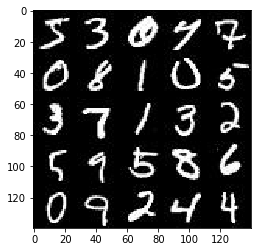

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

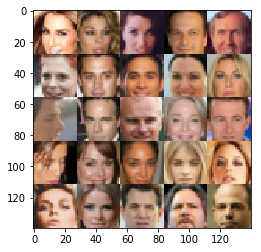

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/fernandomarins/anaconda/envs/dlnd/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(x, alpha=0.05, name='leaky_relu'): 
    return tf.maximum(x, alpha * x, name=name)

def discriminator(images, reuse=False, alpha=0.2, stddev=0.02, rate=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #28x28x16
        layer_1 = tf.layers.conv2d(images, 32, 5, 2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_1 = leaky_relu(layer_1)
        layer_1 = tf.layers.dropout(layer_1, rate, training=True)
        #14x14x32
        
        layer_2 = tf.layers.conv2d(layer_1, 64, 5, 2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_2 = tf.layers.batch_normalization(layer_2, training=True)
        layer_2 = leaky_relu(layer_2)
        layer_2 = tf.layers.dropout(layer_2, rate, training=True)
        #7x7x64
        
        layer_3 = tf.layers.conv2d(layer_2, 128, 5, 2, padding='same',  kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_3 = tf.layers.batch_normalization(layer_3, training=True)        
        layer_3 = leaky_relu(layer_3)
        layer_3 = tf.layers.dropout(layer_3, rate, training=True)
        #4x4x128
        
        layer_4 = tf.layers.conv2d(layer_3, 256, 5, 2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_4 = tf.layers.batch_normalization(layer_4, training=True)
        layer_4 = leaky_relu(layer_4)
        layer_4 = tf.layers.dropout(layer_4, rate, training=True)
        #2x2x256
        
        flattened = tf.reshape(layer_4, (-1, 2 * 2 * 256))
        logits = tf.layers.dense(flattened, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, stddev=0.02, rate=0.5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        #7x7x256
        layer_1 = tf.layers.dense(z, 4 * 4 * 512)
        layer_1 = tf.reshape(layer_1, (-1, 4, 4, 512))
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        layer_1 = leaky_relu(layer_1)
        layer_1 = tf.layers.dropout(layer_1, rate, training=True)
        #4x4x512
        
        layer_2 = tf.layers.conv2d_transpose(layer_1, 128, 4, 1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        layer_2 = leaky_relu(layer_2)
        layer_2 = tf.layers.dropout(layer_2, rate, training=True)
        #8x8x128
        
        layer_3 = tf.layers.conv2d_transpose(layer_2, 64, 5, 2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_3 = tf.layers.batch_normalization(layer_3, training=is_train)
        layer_3 = leaky_relu(layer_3)
        layer_3 = tf.layers.dropout(layer_3, rate, training=True)
        #16x16x64
        
        layer_4 = tf.layers.conv2d_transpose(layer_3, 32, 5, 2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer_4 = tf.layers.batch_normalization(layer_4, training=is_train)
        layer_4 = leaky_relu(layer_4)
        layer_4 = tf.layers.dropout(layer_4, rate, training=True)
        #32x32x32
        
        logits = tf.layers.conv2d_transpose(layer_4, out_channel_dim, 3, 1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_logits_real,
            labels=tf.ones_like(dis_logits_real) * 0.9))
    dis_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_logits_fake,
            labels=tf.zeros_like(dis_logits_fake)))
    
    dis_loss = dis_loss_real + dis_loss_fake
    
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_logits_fake,
            labels=tf.ones_like(dis_logits_fake)))
    
    return dis_loss, gen_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    train_vars = tf.trainable_variables()
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        dis_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
        return dis_train_ops, gen_train_ops


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, in_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    dis_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    dis_ops, gen_ops = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    steps = 0
    
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(dis_ops, feed_dict={ input_real: batch_images, input_z: batch_z, in_learning_rate: learning_rate })
                _ = sess.run(gen_ops, feed_dict={ input_z: batch_z, in_learning_rate: learning_rate })
                
                if steps % print_every == 0:
                    dis_loss_train = dis_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    gen_loss_train = gen_loss.eval({
                        input_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(dis_loss_train),
                         "Generator Loss: {:.4f}".format(gen_loss_train))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/4... Discriminator Loss: 1.3648... Generator Loss: 0.5458
Epoch 1/4... Discriminator Loss: 1.6786... Generator Loss: 0.3738
Epoch 1/4... Discriminator Loss: 0.8780... Generator Loss: 1.4832
Epoch 1/4... Discriminator Loss: 0.8666... Generator Loss: 2.4636
Epoch 1/4... Discriminator Loss: 0.9450... Generator Loss: 0.8835
Epoch 1/4... Discriminator Loss: 0.9008... Generator Loss: 2.3386
Epoch 1/4... Discriminator Loss: 2.2350... Generator Loss: 0.1622
Epoch 1/4... Discriminator Loss: 2.0613... Generator Loss: 2.1936
Epoch 1/4... Discriminator Loss: 1.3076... Generator Loss: 0.6699
Epoch 1/4... Discriminator Loss: 1.2180... Generator Loss: 0.6377


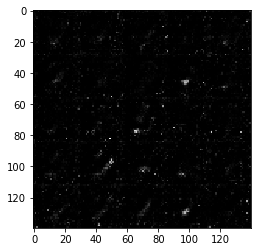

Epoch 1/4... Discriminator Loss: 1.7842... Generator Loss: 2.9332
Epoch 1/4... Discriminator Loss: 1.4049... Generator Loss: 2.6518
Epoch 1/4... Discriminator Loss: 0.9563... Generator Loss: 1.8685
Epoch 1/4... Discriminator Loss: 0.9685... Generator Loss: 1.3833
Epoch 1/4... Discriminator Loss: 0.9321... Generator Loss: 1.1862
Epoch 1/4... Discriminator Loss: 1.1511... Generator Loss: 0.8467
Epoch 1/4... Discriminator Loss: 0.7813... Generator Loss: 1.8853
Epoch 1/4... Discriminator Loss: 1.1053... Generator Loss: 0.8135
Epoch 1/4... Discriminator Loss: 1.4643... Generator Loss: 3.0810
Epoch 1/4... Discriminator Loss: 0.8812... Generator Loss: 1.1512


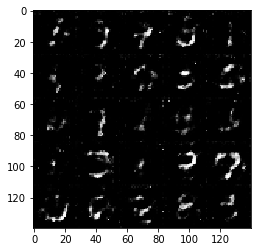

Epoch 1/4... Discriminator Loss: 0.8544... Generator Loss: 1.2480
Epoch 1/4... Discriminator Loss: 1.4262... Generator Loss: 0.7554
Epoch 1/4... Discriminator Loss: 0.9637... Generator Loss: 1.2413
Epoch 1/4... Discriminator Loss: 1.2865... Generator Loss: 0.6266
Epoch 1/4... Discriminator Loss: 0.8159... Generator Loss: 1.5476
Epoch 1/4... Discriminator Loss: 0.7899... Generator Loss: 1.1294
Epoch 1/4... Discriminator Loss: 2.3029... Generator Loss: 0.2687
Epoch 1/4... Discriminator Loss: 1.1127... Generator Loss: 0.9862
Epoch 1/4... Discriminator Loss: 1.7580... Generator Loss: 0.2970
Epoch 1/4... Discriminator Loss: 0.9370... Generator Loss: 1.1944


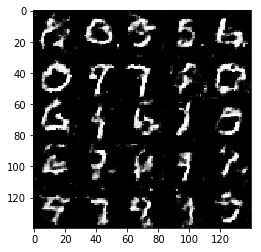

Epoch 1/4... Discriminator Loss: 0.8950... Generator Loss: 1.6415
Epoch 1/4... Discriminator Loss: 0.9564... Generator Loss: 1.2484
Epoch 1/4... Discriminator Loss: 0.8952... Generator Loss: 1.9727
Epoch 1/4... Discriminator Loss: 0.7625... Generator Loss: 1.9188
Epoch 1/4... Discriminator Loss: 0.9143... Generator Loss: 1.3783
Epoch 1/4... Discriminator Loss: 1.0300... Generator Loss: 1.1831
Epoch 1/4... Discriminator Loss: 0.8426... Generator Loss: 1.5435
Epoch 1/4... Discriminator Loss: 0.6482... Generator Loss: 1.9863
Epoch 1/4... Discriminator Loss: 0.9220... Generator Loss: 0.8048
Epoch 1/4... Discriminator Loss: 0.7954... Generator Loss: 1.1530


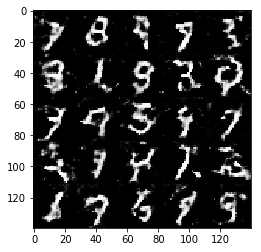

Epoch 1/4... Discriminator Loss: 0.7440... Generator Loss: 1.8456
Epoch 1/4... Discriminator Loss: 0.6611... Generator Loss: 1.2442
Epoch 1/4... Discriminator Loss: 1.0618... Generator Loss: 0.9501
Epoch 1/4... Discriminator Loss: 0.7780... Generator Loss: 1.5208
Epoch 1/4... Discriminator Loss: 0.5166... Generator Loss: 2.8597
Epoch 1/4... Discriminator Loss: 0.9752... Generator Loss: 1.0021
Epoch 1/4... Discriminator Loss: 0.7508... Generator Loss: 2.0125
Epoch 1/4... Discriminator Loss: 0.9088... Generator Loss: 0.7950
Epoch 1/4... Discriminator Loss: 0.7749... Generator Loss: 2.0681
Epoch 1/4... Discriminator Loss: 0.9711... Generator Loss: 3.4647


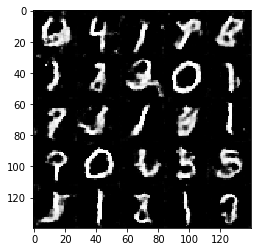

Epoch 1/4... Discriminator Loss: 1.6006... Generator Loss: 4.5294
Epoch 1/4... Discriminator Loss: 0.8300... Generator Loss: 1.2630
Epoch 1/4... Discriminator Loss: 1.1746... Generator Loss: 0.8546
Epoch 1/4... Discriminator Loss: 0.6694... Generator Loss: 2.4278
Epoch 1/4... Discriminator Loss: 0.6991... Generator Loss: 3.3806
Epoch 1/4... Discriminator Loss: 0.7270... Generator Loss: 1.0656
Epoch 1/4... Discriminator Loss: 0.8692... Generator Loss: 1.3270
Epoch 1/4... Discriminator Loss: 1.9570... Generator Loss: 0.2256
Epoch 1/4... Discriminator Loss: 0.6763... Generator Loss: 2.5626
Epoch 1/4... Discriminator Loss: 0.6638... Generator Loss: 2.8877


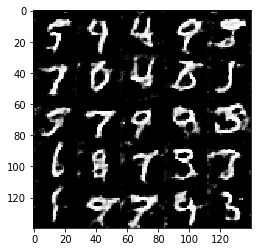

Epoch 1/4... Discriminator Loss: 0.8886... Generator Loss: 0.8263
Epoch 1/4... Discriminator Loss: 0.5071... Generator Loss: 1.7363
Epoch 1/4... Discriminator Loss: 0.9460... Generator Loss: 0.7864
Epoch 1/4... Discriminator Loss: 1.1067... Generator Loss: 0.6742
Epoch 1/4... Discriminator Loss: 0.8446... Generator Loss: 1.2748
Epoch 1/4... Discriminator Loss: 1.3071... Generator Loss: 3.2055
Epoch 1/4... Discriminator Loss: 0.7275... Generator Loss: 1.3824
Epoch 1/4... Discriminator Loss: 1.0068... Generator Loss: 0.7403
Epoch 1/4... Discriminator Loss: 0.6917... Generator Loss: 2.8490
Epoch 1/4... Discriminator Loss: 0.8522... Generator Loss: 1.6259


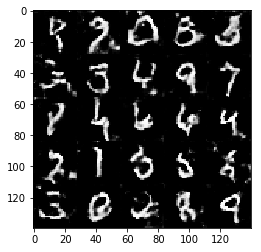

Epoch 1/4... Discriminator Loss: 1.1392... Generator Loss: 0.8894
Epoch 1/4... Discriminator Loss: 0.6167... Generator Loss: 1.7747
Epoch 1/4... Discriminator Loss: 0.9368... Generator Loss: 1.1038
Epoch 1/4... Discriminator Loss: 0.8350... Generator Loss: 1.5460
Epoch 1/4... Discriminator Loss: 0.8793... Generator Loss: 0.8358
Epoch 1/4... Discriminator Loss: 0.4794... Generator Loss: 1.9460
Epoch 1/4... Discriminator Loss: 0.6047... Generator Loss: 1.6103
Epoch 1/4... Discriminator Loss: 0.7762... Generator Loss: 1.1153
Epoch 1/4... Discriminator Loss: 0.8730... Generator Loss: 1.1803
Epoch 1/4... Discriminator Loss: 0.8059... Generator Loss: 1.0202


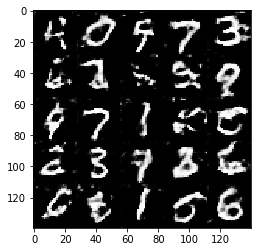

Epoch 1/4... Discriminator Loss: 0.5647... Generator Loss: 2.6213
Epoch 1/4... Discriminator Loss: 0.6083... Generator Loss: 2.2766
Epoch 1/4... Discriminator Loss: 0.6630... Generator Loss: 1.8105
Epoch 1/4... Discriminator Loss: 0.4783... Generator Loss: 1.6837
Epoch 1/4... Discriminator Loss: 0.4551... Generator Loss: 3.8503
Epoch 1/4... Discriminator Loss: 1.3476... Generator Loss: 0.8135
Epoch 1/4... Discriminator Loss: 0.9459... Generator Loss: 1.3248
Epoch 1/4... Discriminator Loss: 0.5110... Generator Loss: 1.7863
Epoch 1/4... Discriminator Loss: 0.9999... Generator Loss: 2.6965
Epoch 1/4... Discriminator Loss: 0.8336... Generator Loss: 1.5823


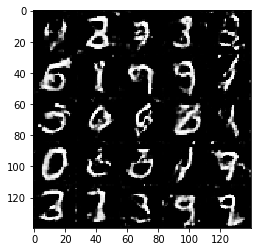

Epoch 1/4... Discriminator Loss: 0.6090... Generator Loss: 1.6125
Epoch 1/4... Discriminator Loss: 0.7750... Generator Loss: 2.4028
Epoch 1/4... Discriminator Loss: 0.5752... Generator Loss: 1.7722
Epoch 2/4... Discriminator Loss: 0.6971... Generator Loss: 1.3397
Epoch 2/4... Discriminator Loss: 0.5169... Generator Loss: 1.9621
Epoch 2/4... Discriminator Loss: 0.6407... Generator Loss: 2.2165
Epoch 2/4... Discriminator Loss: 0.5384... Generator Loss: 1.7730
Epoch 2/4... Discriminator Loss: 0.5344... Generator Loss: 2.2638
Epoch 2/4... Discriminator Loss: 0.8670... Generator Loss: 1.9200
Epoch 2/4... Discriminator Loss: 0.8122... Generator Loss: 1.3390


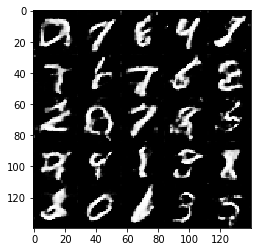

Epoch 2/4... Discriminator Loss: 0.5533... Generator Loss: 2.3639
Epoch 2/4... Discriminator Loss: 0.5247... Generator Loss: 2.6701
Epoch 2/4... Discriminator Loss: 0.5032... Generator Loss: 2.0664
Epoch 2/4... Discriminator Loss: 1.2706... Generator Loss: 0.7888
Epoch 2/4... Discriminator Loss: 0.5556... Generator Loss: 1.5729
Epoch 2/4... Discriminator Loss: 0.6483... Generator Loss: 1.7650
Epoch 2/4... Discriminator Loss: 0.6634... Generator Loss: 2.1948
Epoch 2/4... Discriminator Loss: 0.5248... Generator Loss: 2.4608
Epoch 2/4... Discriminator Loss: 0.5573... Generator Loss: 4.1763
Epoch 2/4... Discriminator Loss: 0.4705... Generator Loss: 2.0068


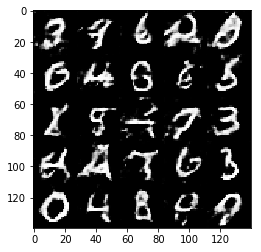

Epoch 2/4... Discriminator Loss: 0.6523... Generator Loss: 1.3804
Epoch 2/4... Discriminator Loss: 0.5016... Generator Loss: 2.4011
Epoch 2/4... Discriminator Loss: 0.5918... Generator Loss: 2.1964
Epoch 2/4... Discriminator Loss: 0.6059... Generator Loss: 2.3168
Epoch 2/4... Discriminator Loss: 0.5083... Generator Loss: 2.3594
Epoch 2/4... Discriminator Loss: 0.5209... Generator Loss: 2.7109
Epoch 2/4... Discriminator Loss: 0.7912... Generator Loss: 4.3828
Epoch 2/4... Discriminator Loss: 0.6321... Generator Loss: 1.7554
Epoch 2/4... Discriminator Loss: 0.7057... Generator Loss: 1.0649
Epoch 2/4... Discriminator Loss: 0.5219... Generator Loss: 2.6668


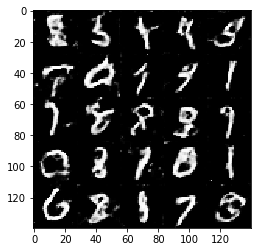

Epoch 2/4... Discriminator Loss: 0.5528... Generator Loss: 2.9436
Epoch 2/4... Discriminator Loss: 1.2422... Generator Loss: 4.6083
Epoch 2/4... Discriminator Loss: 0.4703... Generator Loss: 2.4304
Epoch 2/4... Discriminator Loss: 0.4957... Generator Loss: 2.6884
Epoch 2/4... Discriminator Loss: 1.0054... Generator Loss: 1.6711
Epoch 2/4... Discriminator Loss: 0.7497... Generator Loss: 3.7707
Epoch 2/4... Discriminator Loss: 0.6971... Generator Loss: 2.7749
Epoch 2/4... Discriminator Loss: 0.6875... Generator Loss: 1.6326
Epoch 2/4... Discriminator Loss: 0.4472... Generator Loss: 2.2001
Epoch 2/4... Discriminator Loss: 0.9213... Generator Loss: 0.8897


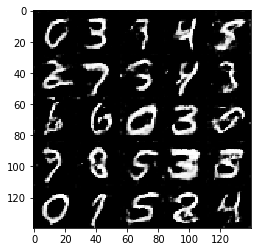

Epoch 2/4... Discriminator Loss: 0.7684... Generator Loss: 0.7972
Epoch 2/4... Discriminator Loss: 0.7320... Generator Loss: 2.0632
Epoch 2/4... Discriminator Loss: 0.5805... Generator Loss: 4.0759
Epoch 2/4... Discriminator Loss: 0.4354... Generator Loss: 1.9966
Epoch 2/4... Discriminator Loss: 0.6320... Generator Loss: 1.9323
Epoch 2/4... Discriminator Loss: 0.4990... Generator Loss: 2.1719
Epoch 2/4... Discriminator Loss: 0.9535... Generator Loss: 1.5068
Epoch 2/4... Discriminator Loss: 0.4496... Generator Loss: 2.7616
Epoch 2/4... Discriminator Loss: 0.7250... Generator Loss: 1.9387
Epoch 2/4... Discriminator Loss: 0.5611... Generator Loss: 2.2432


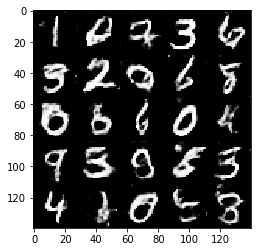

Epoch 2/4... Discriminator Loss: 0.6206... Generator Loss: 1.6563
Epoch 2/4... Discriminator Loss: 0.4180... Generator Loss: 2.8197
Epoch 2/4... Discriminator Loss: 0.7598... Generator Loss: 1.9117
Epoch 2/4... Discriminator Loss: 0.5862... Generator Loss: 3.7157
Epoch 2/4... Discriminator Loss: 0.4869... Generator Loss: 3.3418
Epoch 2/4... Discriminator Loss: 1.0486... Generator Loss: 5.4100
Epoch 2/4... Discriminator Loss: 0.8814... Generator Loss: 1.2410
Epoch 2/4... Discriminator Loss: 0.5417... Generator Loss: 2.8166
Epoch 2/4... Discriminator Loss: 0.4188... Generator Loss: 2.8830
Epoch 2/4... Discriminator Loss: 0.6987... Generator Loss: 4.6156


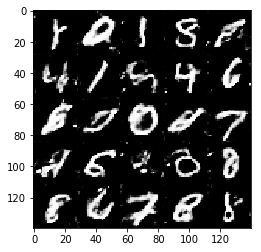

Epoch 2/4... Discriminator Loss: 0.6682... Generator Loss: 3.8770
Epoch 2/4... Discriminator Loss: 0.4626... Generator Loss: 3.0211
Epoch 2/4... Discriminator Loss: 0.4282... Generator Loss: 2.8424
Epoch 2/4... Discriminator Loss: 0.4975... Generator Loss: 2.7736
Epoch 2/4... Discriminator Loss: 0.4861... Generator Loss: 2.7759
Epoch 2/4... Discriminator Loss: 0.4384... Generator Loss: 3.7225
Epoch 2/4... Discriminator Loss: 0.9046... Generator Loss: 1.0832
Epoch 2/4... Discriminator Loss: 0.6857... Generator Loss: 2.2032
Epoch 2/4... Discriminator Loss: 0.9293... Generator Loss: 1.2177
Epoch 2/4... Discriminator Loss: 0.7304... Generator Loss: 3.0453


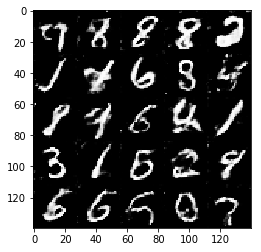

Epoch 2/4... Discriminator Loss: 0.8244... Generator Loss: 1.9079
Epoch 2/4... Discriminator Loss: 0.5373... Generator Loss: 2.5978
Epoch 2/4... Discriminator Loss: 0.6644... Generator Loss: 1.4733
Epoch 2/4... Discriminator Loss: 0.6712... Generator Loss: 2.2231
Epoch 2/4... Discriminator Loss: 0.5836... Generator Loss: 1.6633
Epoch 2/4... Discriminator Loss: 0.6976... Generator Loss: 1.7046
Epoch 2/4... Discriminator Loss: 0.4388... Generator Loss: 2.7426
Epoch 2/4... Discriminator Loss: 0.4606... Generator Loss: 2.8021
Epoch 2/4... Discriminator Loss: 0.4573... Generator Loss: 2.6318
Epoch 2/4... Discriminator Loss: 0.5255... Generator Loss: 2.7911


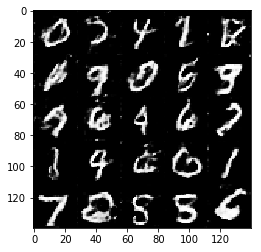

Epoch 2/4... Discriminator Loss: 0.4847... Generator Loss: 2.2552
Epoch 2/4... Discriminator Loss: 0.6430... Generator Loss: 1.7441
Epoch 2/4... Discriminator Loss: 0.5227... Generator Loss: 2.2399
Epoch 2/4... Discriminator Loss: 0.4566... Generator Loss: 2.0907
Epoch 2/4... Discriminator Loss: 0.4337... Generator Loss: 2.1433
Epoch 2/4... Discriminator Loss: 0.4577... Generator Loss: 4.0963
Epoch 2/4... Discriminator Loss: 0.8648... Generator Loss: 3.2293
Epoch 2/4... Discriminator Loss: 0.4545... Generator Loss: 3.3529
Epoch 2/4... Discriminator Loss: 0.3917... Generator Loss: 2.7178
Epoch 2/4... Discriminator Loss: 0.7418... Generator Loss: 1.7932


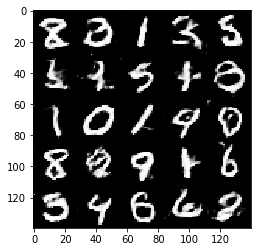

Epoch 2/4... Discriminator Loss: 0.5902... Generator Loss: 1.9370
Epoch 2/4... Discriminator Loss: 0.7936... Generator Loss: 0.4848
Epoch 2/4... Discriminator Loss: 0.6350... Generator Loss: 1.6466
Epoch 2/4... Discriminator Loss: 0.5773... Generator Loss: 2.0149
Epoch 2/4... Discriminator Loss: 1.2317... Generator Loss: 5.5923
Epoch 2/4... Discriminator Loss: 0.7012... Generator Loss: 1.8431
Epoch 2/4... Discriminator Loss: 0.5022... Generator Loss: 2.5880
Epoch 3/4... Discriminator Loss: 0.5965... Generator Loss: 4.5528
Epoch 3/4... Discriminator Loss: 0.5092... Generator Loss: 3.8816
Epoch 3/4... Discriminator Loss: 0.4632... Generator Loss: 2.6145


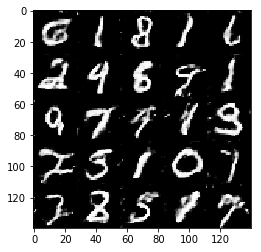

Epoch 3/4... Discriminator Loss: 1.6434... Generator Loss: 0.6680
Epoch 3/4... Discriminator Loss: 0.5966... Generator Loss: 1.7017
Epoch 3/4... Discriminator Loss: 0.4383... Generator Loss: 2.3503
Epoch 3/4... Discriminator Loss: 0.8284... Generator Loss: 1.2500
Epoch 3/4... Discriminator Loss: 1.4227... Generator Loss: 0.4514
Epoch 3/4... Discriminator Loss: 0.5309... Generator Loss: 2.9151
Epoch 3/4... Discriminator Loss: 0.8207... Generator Loss: 1.0453
Epoch 3/4... Discriminator Loss: 0.4808... Generator Loss: 3.9834
Epoch 3/4... Discriminator Loss: 0.7107... Generator Loss: 4.6843
Epoch 3/4... Discriminator Loss: 1.0275... Generator Loss: 0.7655


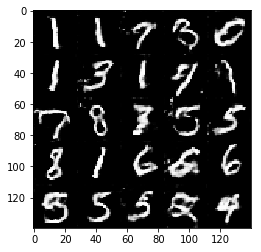

Epoch 3/4... Discriminator Loss: 0.5557... Generator Loss: 2.4158
Epoch 3/4... Discriminator Loss: 0.5867... Generator Loss: 1.8566
Epoch 3/4... Discriminator Loss: 0.3679... Generator Loss: 5.0688
Epoch 3/4... Discriminator Loss: 0.5084... Generator Loss: 2.7798
Epoch 3/4... Discriminator Loss: 0.4869... Generator Loss: 2.5786
Epoch 3/4... Discriminator Loss: 0.6290... Generator Loss: 4.5594
Epoch 3/4... Discriminator Loss: 0.4452... Generator Loss: 3.5556
Epoch 3/4... Discriminator Loss: 0.5381... Generator Loss: 3.6677
Epoch 3/4... Discriminator Loss: 0.4462... Generator Loss: 3.7925
Epoch 3/4... Discriminator Loss: 0.6522... Generator Loss: 1.1676


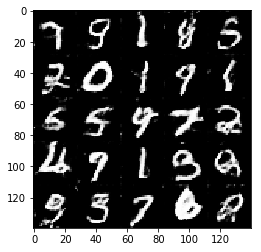

Epoch 3/4... Discriminator Loss: 0.4037... Generator Loss: 2.6734
Epoch 3/4... Discriminator Loss: 0.5588... Generator Loss: 3.4172
Epoch 3/4... Discriminator Loss: 0.4072... Generator Loss: 3.2159
Epoch 3/4... Discriminator Loss: 0.4486... Generator Loss: 3.9839
Epoch 3/4... Discriminator Loss: 0.5235... Generator Loss: 2.5944
Epoch 3/4... Discriminator Loss: 0.5592... Generator Loss: 2.2461
Epoch 3/4... Discriminator Loss: 0.8321... Generator Loss: 1.4830
Epoch 3/4... Discriminator Loss: 0.6350... Generator Loss: 1.8191
Epoch 3/4... Discriminator Loss: 0.7861... Generator Loss: 1.3967
Epoch 3/4... Discriminator Loss: 0.5435... Generator Loss: 2.3769


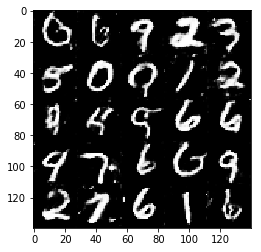

Epoch 3/4... Discriminator Loss: 0.5881... Generator Loss: 2.0191
Epoch 3/4... Discriminator Loss: 0.5859... Generator Loss: 2.3091
Epoch 3/4... Discriminator Loss: 0.4267... Generator Loss: 3.4463
Epoch 3/4... Discriminator Loss: 0.6786... Generator Loss: 1.2754
Epoch 3/4... Discriminator Loss: 0.4522... Generator Loss: 3.2000
Epoch 3/4... Discriminator Loss: 0.4970... Generator Loss: 2.9410
Epoch 3/4... Discriminator Loss: 0.6706... Generator Loss: 3.4102
Epoch 3/4... Discriminator Loss: 0.4666... Generator Loss: 2.7988
Epoch 3/4... Discriminator Loss: 0.6073... Generator Loss: 1.9719
Epoch 3/4... Discriminator Loss: 0.5283... Generator Loss: 2.0506


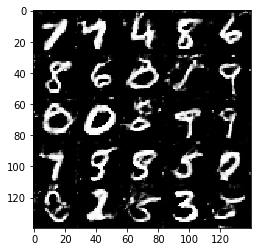

Epoch 3/4... Discriminator Loss: 0.4211... Generator Loss: 3.5292
Epoch 3/4... Discriminator Loss: 0.5583... Generator Loss: 1.9104
Epoch 3/4... Discriminator Loss: 0.6482... Generator Loss: 2.0821
Epoch 3/4... Discriminator Loss: 0.4676... Generator Loss: 2.6462
Epoch 3/4... Discriminator Loss: 0.3930... Generator Loss: 4.6572
Epoch 3/4... Discriminator Loss: 0.4243... Generator Loss: 2.0977
Epoch 3/4... Discriminator Loss: 0.6010... Generator Loss: 3.5786
Epoch 3/4... Discriminator Loss: 1.4176... Generator Loss: 0.4514
Epoch 3/4... Discriminator Loss: 0.4867... Generator Loss: 2.1306
Epoch 3/4... Discriminator Loss: 0.3800... Generator Loss: 2.6756


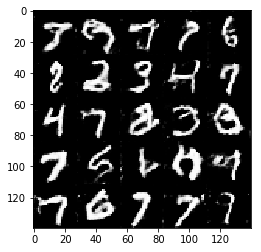

Epoch 3/4... Discriminator Loss: 0.3851... Generator Loss: 5.2428
Epoch 3/4... Discriminator Loss: 0.4370... Generator Loss: 3.0278
Epoch 3/4... Discriminator Loss: 0.7186... Generator Loss: 1.4075
Epoch 3/4... Discriminator Loss: 0.8134... Generator Loss: 0.7960
Epoch 3/4... Discriminator Loss: 1.0717... Generator Loss: 5.9106
Epoch 3/4... Discriminator Loss: 0.6368... Generator Loss: 2.0452
Epoch 3/4... Discriminator Loss: 0.4404... Generator Loss: 2.8877
Epoch 3/4... Discriminator Loss: 0.5226... Generator Loss: 2.2528
Epoch 3/4... Discriminator Loss: 0.5313... Generator Loss: 3.3468
Epoch 3/4... Discriminator Loss: 0.4303... Generator Loss: 2.7948


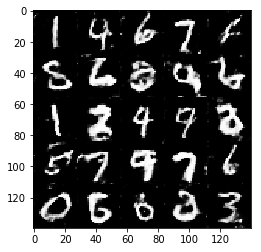

Epoch 3/4... Discriminator Loss: 0.6248... Generator Loss: 1.2200
Epoch 3/4... Discriminator Loss: 0.4611... Generator Loss: 3.3619
Epoch 3/4... Discriminator Loss: 0.4550... Generator Loss: 3.8662
Epoch 3/4... Discriminator Loss: 0.5891... Generator Loss: 2.2844
Epoch 3/4... Discriminator Loss: 0.7659... Generator Loss: 1.2821
Epoch 3/4... Discriminator Loss: 0.4800... Generator Loss: 3.1051
Epoch 3/4... Discriminator Loss: 0.8399... Generator Loss: 1.4130
Epoch 3/4... Discriminator Loss: 0.5791... Generator Loss: 3.8323
Epoch 3/4... Discriminator Loss: 0.5686... Generator Loss: 2.9923
Epoch 3/4... Discriminator Loss: 0.4785... Generator Loss: 6.8925


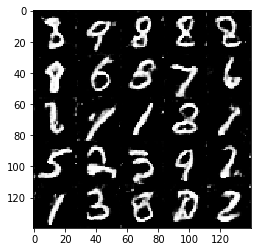

Epoch 3/4... Discriminator Loss: 0.5429... Generator Loss: 3.8639
Epoch 3/4... Discriminator Loss: 0.5162... Generator Loss: 2.7331
Epoch 3/4... Discriminator Loss: 0.4875... Generator Loss: 2.8386
Epoch 3/4... Discriminator Loss: 0.4149... Generator Loss: 2.8385
Epoch 3/4... Discriminator Loss: 0.5449... Generator Loss: 2.4062
Epoch 3/4... Discriminator Loss: 0.4202... Generator Loss: 3.5934
Epoch 3/4... Discriminator Loss: 0.4096... Generator Loss: 5.5300
Epoch 3/4... Discriminator Loss: 1.3267... Generator Loss: 7.3857
Epoch 3/4... Discriminator Loss: 0.4997... Generator Loss: 3.4920
Epoch 3/4... Discriminator Loss: 0.5439... Generator Loss: 2.9846


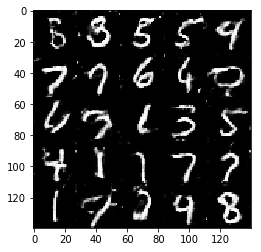

Epoch 3/4... Discriminator Loss: 0.4026... Generator Loss: 3.2180
Epoch 3/4... Discriminator Loss: 0.4536... Generator Loss: 3.7722
Epoch 3/4... Discriminator Loss: 0.6274... Generator Loss: 1.6819
Epoch 3/4... Discriminator Loss: 0.7597... Generator Loss: 2.3511
Epoch 3/4... Discriminator Loss: 0.5767... Generator Loss: 3.2675
Epoch 3/4... Discriminator Loss: 0.4324... Generator Loss: 2.8582
Epoch 3/4... Discriminator Loss: 0.4175... Generator Loss: 2.8478
Epoch 3/4... Discriminator Loss: 0.4143... Generator Loss: 3.8000
Epoch 3/4... Discriminator Loss: 1.1381... Generator Loss: 4.0317
Epoch 3/4... Discriminator Loss: 0.7175... Generator Loss: 1.9882


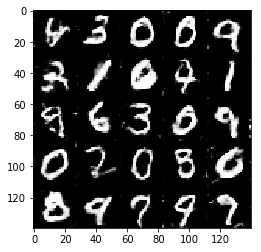

Epoch 3/4... Discriminator Loss: 0.3876... Generator Loss: 3.6911
Epoch 4/4... Discriminator Loss: 0.5146... Generator Loss: 2.5145
Epoch 4/4... Discriminator Loss: 0.5699... Generator Loss: 3.4254
Epoch 4/4... Discriminator Loss: 0.8427... Generator Loss: 1.2628
Epoch 4/4... Discriminator Loss: 0.4717... Generator Loss: 2.6732
Epoch 4/4... Discriminator Loss: 0.5789... Generator Loss: 1.9397
Epoch 4/4... Discriminator Loss: 0.4947... Generator Loss: 2.1020
Epoch 4/4... Discriminator Loss: 0.3679... Generator Loss: 4.6077
Epoch 4/4... Discriminator Loss: 0.9590... Generator Loss: 0.7759
Epoch 4/4... Discriminator Loss: 0.6638... Generator Loss: 3.2774


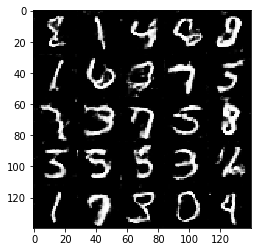

Epoch 4/4... Discriminator Loss: 0.4053... Generator Loss: 3.8384
Epoch 4/4... Discriminator Loss: 0.4335... Generator Loss: 4.6811
Epoch 4/4... Discriminator Loss: 0.4215... Generator Loss: 2.3080
Epoch 4/4... Discriminator Loss: 0.4324... Generator Loss: 3.3820
Epoch 4/4... Discriminator Loss: 0.4227... Generator Loss: 2.3526
Epoch 4/4... Discriminator Loss: 1.4118... Generator Loss: 0.4462
Epoch 4/4... Discriminator Loss: 0.3878... Generator Loss: 4.4637
Epoch 4/4... Discriminator Loss: 0.4560... Generator Loss: 4.4487
Epoch 4/4... Discriminator Loss: 0.4063... Generator Loss: 4.1559
Epoch 4/4... Discriminator Loss: 0.5073... Generator Loss: 2.3343


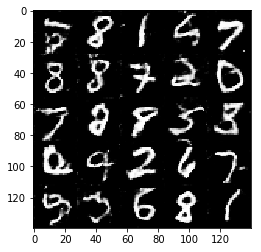

Epoch 4/4... Discriminator Loss: 0.3882... Generator Loss: 3.8135
Epoch 4/4... Discriminator Loss: 0.3964... Generator Loss: 4.6357
Epoch 4/4... Discriminator Loss: 0.4550... Generator Loss: 3.8913
Epoch 4/4... Discriminator Loss: 0.4330... Generator Loss: 3.2282
Epoch 4/4... Discriminator Loss: 0.4333... Generator Loss: 3.8782
Epoch 4/4... Discriminator Loss: 0.4031... Generator Loss: 3.6260
Epoch 4/4... Discriminator Loss: 0.3918... Generator Loss: 3.1011
Epoch 4/4... Discriminator Loss: 0.4138... Generator Loss: 3.0357
Epoch 4/4... Discriminator Loss: 0.3917... Generator Loss: 2.8969
Epoch 4/4... Discriminator Loss: 0.4392... Generator Loss: 3.7418


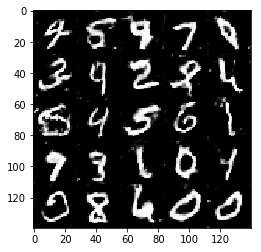

Epoch 4/4... Discriminator Loss: 0.4258... Generator Loss: 3.5712
Epoch 4/4... Discriminator Loss: 0.4897... Generator Loss: 2.9243
Epoch 4/4... Discriminator Loss: 0.6210... Generator Loss: 2.1210
Epoch 4/4... Discriminator Loss: 0.4509... Generator Loss: 2.3354
Epoch 4/4... Discriminator Loss: 0.4916... Generator Loss: 2.0848
Epoch 4/4... Discriminator Loss: 1.7041... Generator Loss: 0.5308
Epoch 4/4... Discriminator Loss: 0.3831... Generator Loss: 4.6923
Epoch 4/4... Discriminator Loss: 0.7502... Generator Loss: 2.4017
Epoch 4/4... Discriminator Loss: 0.4235... Generator Loss: 2.6300
Epoch 4/4... Discriminator Loss: 0.5998... Generator Loss: 1.9875


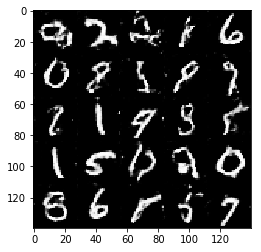

Epoch 4/4... Discriminator Loss: 0.5321... Generator Loss: 3.4265
Epoch 4/4... Discriminator Loss: 0.4647... Generator Loss: 4.5624
Epoch 4/4... Discriminator Loss: 0.4061... Generator Loss: 3.4942
Epoch 4/4... Discriminator Loss: 1.0099... Generator Loss: 1.0845
Epoch 4/4... Discriminator Loss: 1.1003... Generator Loss: 1.1648
Epoch 4/4... Discriminator Loss: 0.5300... Generator Loss: 4.2446
Epoch 4/4... Discriminator Loss: 0.4205... Generator Loss: 4.5728
Epoch 4/4... Discriminator Loss: 0.7701... Generator Loss: 2.9936
Epoch 4/4... Discriminator Loss: 0.3970... Generator Loss: 3.7163
Epoch 4/4... Discriminator Loss: 0.4429... Generator Loss: 3.6299


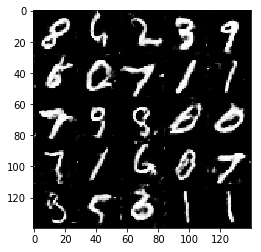

Epoch 4/4... Discriminator Loss: 0.3937... Generator Loss: 3.5900
Epoch 4/4... Discriminator Loss: 1.8855... Generator Loss: 1.1645
Epoch 4/4... Discriminator Loss: 0.4643... Generator Loss: 1.9831
Epoch 4/4... Discriminator Loss: 0.3719... Generator Loss: 3.7923
Epoch 4/4... Discriminator Loss: 0.4005... Generator Loss: 3.2864
Epoch 4/4... Discriminator Loss: 0.3730... Generator Loss: 4.5776
Epoch 4/4... Discriminator Loss: 0.4256... Generator Loss: 3.6182
Epoch 4/4... Discriminator Loss: 0.3783... Generator Loss: 3.8147
Epoch 4/4... Discriminator Loss: 0.5584... Generator Loss: 4.3693
Epoch 4/4... Discriminator Loss: 0.3954... Generator Loss: 4.0516


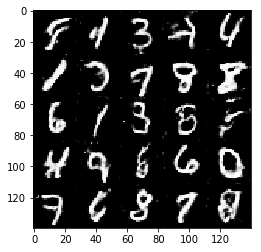

Epoch 4/4... Discriminator Loss: 0.4342... Generator Loss: 3.9877
Epoch 4/4... Discriminator Loss: 1.0164... Generator Loss: 1.3759
Epoch 4/4... Discriminator Loss: 0.4337... Generator Loss: 3.9865
Epoch 4/4... Discriminator Loss: 0.6618... Generator Loss: 1.9758
Epoch 4/4... Discriminator Loss: 0.3925... Generator Loss: 4.6579
Epoch 4/4... Discriminator Loss: 0.3862... Generator Loss: 2.5757
Epoch 4/4... Discriminator Loss: 0.4892... Generator Loss: 2.3964
Epoch 4/4... Discriminator Loss: 0.4102... Generator Loss: 3.8296
Epoch 4/4... Discriminator Loss: 1.0249... Generator Loss: 2.8723
Epoch 4/4... Discriminator Loss: 0.3924... Generator Loss: 5.0846


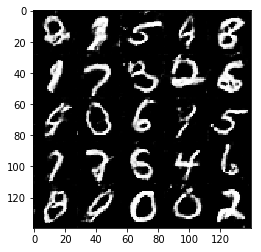

Epoch 4/4... Discriminator Loss: 0.4037... Generator Loss: 3.6454
Epoch 4/4... Discriminator Loss: 0.6432... Generator Loss: 1.9959
Epoch 4/4... Discriminator Loss: 0.4145... Generator Loss: 2.4759
Epoch 4/4... Discriminator Loss: 0.4657... Generator Loss: 1.7007
Epoch 4/4... Discriminator Loss: 0.7819... Generator Loss: 6.3697
Epoch 4/4... Discriminator Loss: 0.4920... Generator Loss: 3.0547
Epoch 4/4... Discriminator Loss: 0.4448... Generator Loss: 3.4577
Epoch 4/4... Discriminator Loss: 0.4092... Generator Loss: 2.6368
Epoch 4/4... Discriminator Loss: 0.6792... Generator Loss: 5.6470
Epoch 4/4... Discriminator Loss: 0.4234... Generator Loss: 2.7468


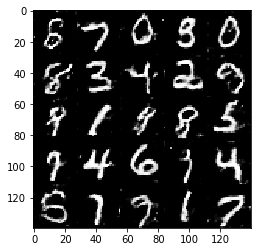

Epoch 4/4... Discriminator Loss: 0.3987... Generator Loss: 4.3969
Epoch 4/4... Discriminator Loss: 0.5693... Generator Loss: 1.5130
Epoch 4/4... Discriminator Loss: 0.5968... Generator Loss: 5.6004
Epoch 4/4... Discriminator Loss: 0.9316... Generator Loss: 0.9185
Epoch 4/4... Discriminator Loss: 0.3951... Generator Loss: 3.5621
Epoch 4/4... Discriminator Loss: 0.4493... Generator Loss: 3.8240
Epoch 4/4... Discriminator Loss: 0.6144... Generator Loss: 3.9104
Epoch 4/4... Discriminator Loss: 1.9033... Generator Loss: 0.5638
Epoch 4/4... Discriminator Loss: 0.5507... Generator Loss: 3.3262
Epoch 4/4... Discriminator Loss: 0.8818... Generator Loss: 2.7201


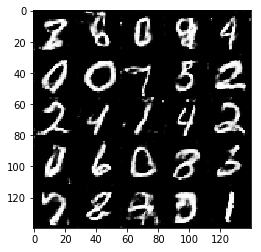

Epoch 4/4... Discriminator Loss: 0.4068... Generator Loss: 2.8673
Epoch 4/4... Discriminator Loss: 0.4429... Generator Loss: 3.3088
Epoch 4/4... Discriminator Loss: 0.4422... Generator Loss: 3.4816
Epoch 4/4... Discriminator Loss: 0.5347... Generator Loss: 2.5307


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/4... Discriminator Loss: 1.7392... Generator Loss: 7.6808
Epoch 1/4... Discriminator Loss: 1.3404... Generator Loss: 6.1234
Epoch 1/4... Discriminator Loss: 0.4939... Generator Loss: 2.3674
Epoch 1/4... Discriminator Loss: 0.4143... Generator Loss: 3.8906
Epoch 1/4... Discriminator Loss: 0.4529... Generator Loss: 2.7051
Epoch 1/4... Discriminator Loss: 0.4927... Generator Loss: 2.4136
Epoch 1/4... Discriminator Loss: 0.3950... Generator Loss: 3.2371
Epoch 1/4... Discriminator Loss: 0.3958... Generator Loss: 3.2552
Epoch 1/4... Discriminator Loss: 0.7459... Generator Loss: 1.2624
Epoch 1/4... Discriminator Loss: 0.5528... Generator Loss: 1.8264


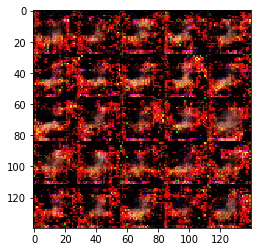

Epoch 1/4... Discriminator Loss: 1.8501... Generator Loss: 2.5940
Epoch 1/4... Discriminator Loss: 2.0886... Generator Loss: 4.0455
Epoch 1/4... Discriminator Loss: 0.7427... Generator Loss: 2.1658
Epoch 1/4... Discriminator Loss: 0.7654... Generator Loss: 1.2041
Epoch 1/4... Discriminator Loss: 1.5103... Generator Loss: 0.4730
Epoch 1/4... Discriminator Loss: 0.4893... Generator Loss: 2.9453
Epoch 1/4... Discriminator Loss: 0.8945... Generator Loss: 1.0811
Epoch 1/4... Discriminator Loss: 0.6471... Generator Loss: 1.3203
Epoch 1/4... Discriminator Loss: 1.5885... Generator Loss: 0.4643
Epoch 1/4... Discriminator Loss: 0.5396... Generator Loss: 2.0521


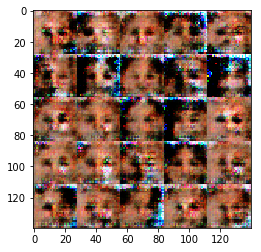

Epoch 1/4... Discriminator Loss: 0.6661... Generator Loss: 1.9603
Epoch 1/4... Discriminator Loss: 0.8450... Generator Loss: 1.0787
Epoch 1/4... Discriminator Loss: 1.4768... Generator Loss: 0.6082
Epoch 1/4... Discriminator Loss: 0.7088... Generator Loss: 1.4665
Epoch 1/4... Discriminator Loss: 0.7709... Generator Loss: 1.3233
Epoch 1/4... Discriminator Loss: 1.3362... Generator Loss: 1.2463
Epoch 1/4... Discriminator Loss: 0.8758... Generator Loss: 1.5804
Epoch 1/4... Discriminator Loss: 1.4109... Generator Loss: 0.5846
Epoch 1/4... Discriminator Loss: 1.3386... Generator Loss: 0.5340
Epoch 1/4... Discriminator Loss: 0.5505... Generator Loss: 2.3475


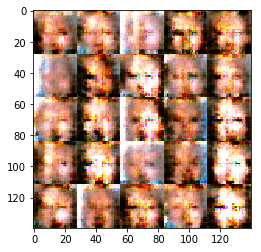

Epoch 1/4... Discriminator Loss: 1.2475... Generator Loss: 3.5515
Epoch 1/4... Discriminator Loss: 1.9902... Generator Loss: 3.6035
Epoch 1/4... Discriminator Loss: 0.7522... Generator Loss: 1.6463
Epoch 1/4... Discriminator Loss: 0.9248... Generator Loss: 0.9712
Epoch 1/4... Discriminator Loss: 0.8757... Generator Loss: 1.5716
Epoch 1/4... Discriminator Loss: 1.6760... Generator Loss: 2.9238
Epoch 1/4... Discriminator Loss: 1.1215... Generator Loss: 1.0498
Epoch 1/4... Discriminator Loss: 1.2041... Generator Loss: 0.5310
Epoch 1/4... Discriminator Loss: 0.8736... Generator Loss: 1.1051
Epoch 1/4... Discriminator Loss: 1.1995... Generator Loss: 1.4939


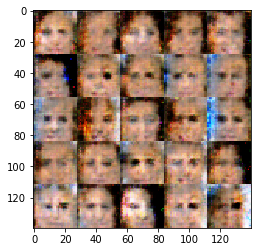

Epoch 1/4... Discriminator Loss: 1.0102... Generator Loss: 1.0159
Epoch 1/4... Discriminator Loss: 0.9924... Generator Loss: 0.9437
Epoch 1/4... Discriminator Loss: 0.8721... Generator Loss: 1.1190
Epoch 1/4... Discriminator Loss: 1.2290... Generator Loss: 1.4231
Epoch 1/4... Discriminator Loss: 0.8317... Generator Loss: 1.7779
Epoch 1/4... Discriminator Loss: 1.5515... Generator Loss: 0.4867
Epoch 1/4... Discriminator Loss: 1.0388... Generator Loss: 1.0834
Epoch 1/4... Discriminator Loss: 0.9687... Generator Loss: 0.9377
Epoch 1/4... Discriminator Loss: 0.8398... Generator Loss: 1.5074
Epoch 1/4... Discriminator Loss: 0.9042... Generator Loss: 2.3339


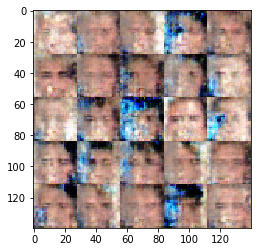

Epoch 1/4... Discriminator Loss: 1.0147... Generator Loss: 1.1092
Epoch 1/4... Discriminator Loss: 1.7062... Generator Loss: 0.3916
Epoch 1/4... Discriminator Loss: 1.7714... Generator Loss: 3.4428
Epoch 1/4... Discriminator Loss: 0.9412... Generator Loss: 1.5744
Epoch 1/4... Discriminator Loss: 1.1528... Generator Loss: 2.7331
Epoch 1/4... Discriminator Loss: 0.9126... Generator Loss: 1.0758
Epoch 1/4... Discriminator Loss: 1.4052... Generator Loss: 3.1377
Epoch 1/4... Discriminator Loss: 1.1288... Generator Loss: 0.6137
Epoch 1/4... Discriminator Loss: 0.7789... Generator Loss: 1.6457
Epoch 1/4... Discriminator Loss: 1.1011... Generator Loss: 2.7453


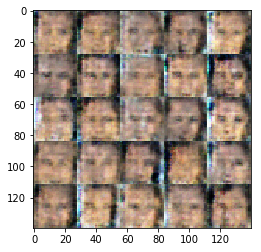

Epoch 1/4... Discriminator Loss: 0.6078... Generator Loss: 1.5802
Epoch 1/4... Discriminator Loss: 0.9229... Generator Loss: 1.1312
Epoch 1/4... Discriminator Loss: 0.7905... Generator Loss: 1.4647
Epoch 1/4... Discriminator Loss: 1.0801... Generator Loss: 2.8023
Epoch 1/4... Discriminator Loss: 1.1111... Generator Loss: 2.9154
Epoch 1/4... Discriminator Loss: 1.9804... Generator Loss: 0.3276
Epoch 1/4... Discriminator Loss: 0.9487... Generator Loss: 1.6252
Epoch 1/4... Discriminator Loss: 1.0324... Generator Loss: 0.8490
Epoch 1/4... Discriminator Loss: 2.2387... Generator Loss: 0.2271
Epoch 1/4... Discriminator Loss: 1.4983... Generator Loss: 3.2529


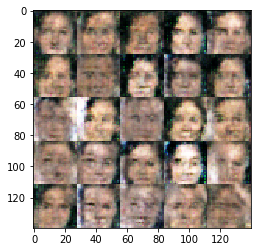

Epoch 1/4... Discriminator Loss: 1.3106... Generator Loss: 0.7061
Epoch 1/4... Discriminator Loss: 0.8417... Generator Loss: 1.1192
Epoch 1/4... Discriminator Loss: 1.7628... Generator Loss: 3.7777
Epoch 1/4... Discriminator Loss: 0.8672... Generator Loss: 1.1232
Epoch 1/4... Discriminator Loss: 0.8205... Generator Loss: 1.2751
Epoch 1/4... Discriminator Loss: 1.6516... Generator Loss: 0.2818
Epoch 1/4... Discriminator Loss: 0.9117... Generator Loss: 1.8642
Epoch 1/4... Discriminator Loss: 2.0265... Generator Loss: 0.3752
Epoch 1/4... Discriminator Loss: 0.9624... Generator Loss: 1.6931
Epoch 1/4... Discriminator Loss: 0.7899... Generator Loss: 2.3014


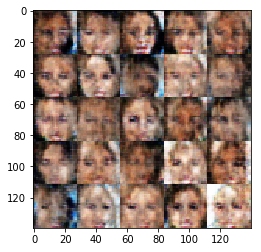

Epoch 1/4... Discriminator Loss: 0.7965... Generator Loss: 1.5337
Epoch 1/4... Discriminator Loss: 0.8281... Generator Loss: 1.1496
Epoch 1/4... Discriminator Loss: 1.2991... Generator Loss: 0.5897
Epoch 1/4... Discriminator Loss: 1.3704... Generator Loss: 0.5115
Epoch 1/4... Discriminator Loss: 0.7858... Generator Loss: 1.1703
Epoch 1/4... Discriminator Loss: 0.8029... Generator Loss: 0.9069
Epoch 1/4... Discriminator Loss: 2.0686... Generator Loss: 0.2276
Epoch 1/4... Discriminator Loss: 0.6978... Generator Loss: 1.8711
Epoch 1/4... Discriminator Loss: 0.9084... Generator Loss: 1.3093
Epoch 1/4... Discriminator Loss: 1.0332... Generator Loss: 1.1996


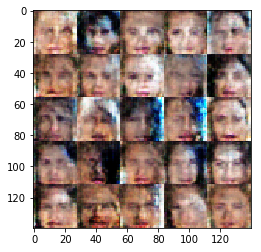

Epoch 1/4... Discriminator Loss: 0.9948... Generator Loss: 0.8279
Epoch 1/4... Discriminator Loss: 1.3348... Generator Loss: 0.8799
Epoch 1/4... Discriminator Loss: 1.5872... Generator Loss: 0.2615
Epoch 1/4... Discriminator Loss: 1.0164... Generator Loss: 1.4671
Epoch 1/4... Discriminator Loss: 0.5903... Generator Loss: 2.0277
Epoch 1/4... Discriminator Loss: 1.7901... Generator Loss: 3.3305
Epoch 1/4... Discriminator Loss: 1.0043... Generator Loss: 0.7406
Epoch 1/4... Discriminator Loss: 1.4377... Generator Loss: 0.5176
Epoch 1/4... Discriminator Loss: 1.3534... Generator Loss: 0.6269
Epoch 1/4... Discriminator Loss: 0.8721... Generator Loss: 1.2132


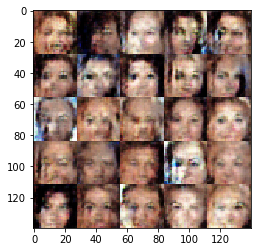

Epoch 1/4... Discriminator Loss: 0.8372... Generator Loss: 1.2406
Epoch 1/4... Discriminator Loss: 0.8004... Generator Loss: 1.7070
Epoch 1/4... Discriminator Loss: 0.8251... Generator Loss: 1.9830
Epoch 1/4... Discriminator Loss: 0.7618... Generator Loss: 1.5543
Epoch 1/4... Discriminator Loss: 0.9715... Generator Loss: 0.8943
Epoch 1/4... Discriminator Loss: 0.6775... Generator Loss: 1.3583
Epoch 1/4... Discriminator Loss: 1.5112... Generator Loss: 0.7031
Epoch 1/4... Discriminator Loss: 0.8348... Generator Loss: 1.1441
Epoch 1/4... Discriminator Loss: 0.6973... Generator Loss: 1.0955
Epoch 1/4... Discriminator Loss: 0.8541... Generator Loss: 3.2756


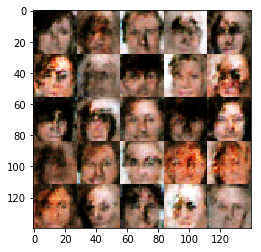

Epoch 1/4... Discriminator Loss: 1.0646... Generator Loss: 2.3848
Epoch 1/4... Discriminator Loss: 0.8798... Generator Loss: 1.0154
Epoch 1/4... Discriminator Loss: 0.9217... Generator Loss: 1.3023
Epoch 1/4... Discriminator Loss: 0.7439... Generator Loss: 1.2910
Epoch 1/4... Discriminator Loss: 1.0837... Generator Loss: 0.8274
Epoch 1/4... Discriminator Loss: 1.4941... Generator Loss: 4.7800
Epoch 1/4... Discriminator Loss: 0.7782... Generator Loss: 1.1574
Epoch 1/4... Discriminator Loss: 0.7340... Generator Loss: 1.5451
Epoch 1/4... Discriminator Loss: 1.7273... Generator Loss: 0.2996
Epoch 1/4... Discriminator Loss: 0.7297... Generator Loss: 1.9051


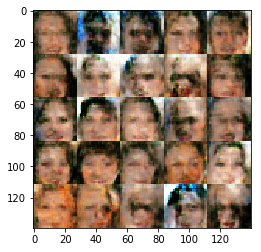

Epoch 1/4... Discriminator Loss: 1.3295... Generator Loss: 3.2705
Epoch 1/4... Discriminator Loss: 1.0111... Generator Loss: 0.8589
Epoch 1/4... Discriminator Loss: 1.0014... Generator Loss: 2.8190
Epoch 1/4... Discriminator Loss: 0.7856... Generator Loss: 1.3172
Epoch 1/4... Discriminator Loss: 1.2247... Generator Loss: 3.1300
Epoch 1/4... Discriminator Loss: 0.9233... Generator Loss: 3.3106
Epoch 1/4... Discriminator Loss: 0.8471... Generator Loss: 1.3179
Epoch 1/4... Discriminator Loss: 1.0215... Generator Loss: 1.3413
Epoch 1/4... Discriminator Loss: 1.0005... Generator Loss: 0.9413
Epoch 1/4... Discriminator Loss: 1.0714... Generator Loss: 0.7121


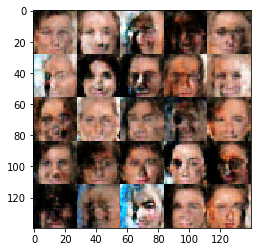

Epoch 1/4... Discriminator Loss: 0.7243... Generator Loss: 1.4979
Epoch 1/4... Discriminator Loss: 0.7933... Generator Loss: 0.9666
Epoch 1/4... Discriminator Loss: 1.0181... Generator Loss: 0.9044
Epoch 1/4... Discriminator Loss: 5.1941... Generator Loss: 7.2671
Epoch 1/4... Discriminator Loss: 1.2012... Generator Loss: 0.7364
Epoch 1/4... Discriminator Loss: 1.1660... Generator Loss: 2.6715
Epoch 1/4... Discriminator Loss: 1.2340... Generator Loss: 0.7335
Epoch 1/4... Discriminator Loss: 0.6089... Generator Loss: 2.3032
Epoch 1/4... Discriminator Loss: 1.5853... Generator Loss: 0.3987
Epoch 1/4... Discriminator Loss: 0.9484... Generator Loss: 2.4038


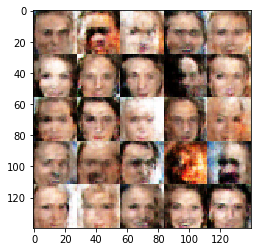

Epoch 1/4... Discriminator Loss: 0.7081... Generator Loss: 1.4873
Epoch 1/4... Discriminator Loss: 0.9319... Generator Loss: 1.1790
Epoch 1/4... Discriminator Loss: 0.9911... Generator Loss: 0.9941
Epoch 1/4... Discriminator Loss: 0.6667... Generator Loss: 3.2810
Epoch 1/4... Discriminator Loss: 0.8868... Generator Loss: 0.9281
Epoch 1/4... Discriminator Loss: 0.8845... Generator Loss: 2.3555
Epoch 1/4... Discriminator Loss: 1.1175... Generator Loss: 0.9868
Epoch 1/4... Discriminator Loss: 0.8453... Generator Loss: 1.2308
Epoch 1/4... Discriminator Loss: 0.4860... Generator Loss: 2.4516
Epoch 1/4... Discriminator Loss: 0.7531... Generator Loss: 2.3807


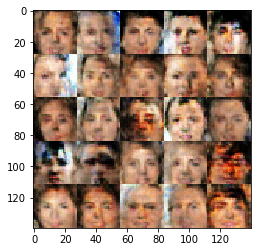

Epoch 1/4... Discriminator Loss: 0.6480... Generator Loss: 2.0131
Epoch 1/4... Discriminator Loss: 1.0154... Generator Loss: 2.7288
Epoch 1/4... Discriminator Loss: 1.4045... Generator Loss: 4.6048
Epoch 1/4... Discriminator Loss: 0.6472... Generator Loss: 2.2840
Epoch 1/4... Discriminator Loss: 0.5559... Generator Loss: 1.7149
Epoch 1/4... Discriminator Loss: 0.8609... Generator Loss: 2.8734
Epoch 1/4... Discriminator Loss: 0.4809... Generator Loss: 1.9638
Epoch 1/4... Discriminator Loss: 0.5809... Generator Loss: 2.1953
Epoch 1/4... Discriminator Loss: 0.9745... Generator Loss: 3.6010
Epoch 1/4... Discriminator Loss: 0.8592... Generator Loss: 1.4315


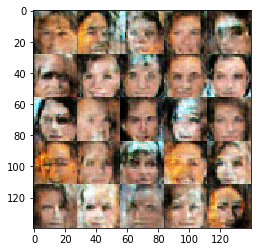

Epoch 1/4... Discriminator Loss: 2.6344... Generator Loss: 4.9349
Epoch 1/4... Discriminator Loss: 0.8502... Generator Loss: 1.3560
Epoch 1/4... Discriminator Loss: 0.8954... Generator Loss: 0.8027
Epoch 1/4... Discriminator Loss: 1.1321... Generator Loss: 0.6774
Epoch 1/4... Discriminator Loss: 0.6754... Generator Loss: 1.5782
Epoch 1/4... Discriminator Loss: 0.6444... Generator Loss: 1.9004
Epoch 1/4... Discriminator Loss: 0.7896... Generator Loss: 1.1496
Epoch 1/4... Discriminator Loss: 0.9345... Generator Loss: 3.8466
Epoch 1/4... Discriminator Loss: 0.8904... Generator Loss: 1.3093
Epoch 1/4... Discriminator Loss: 0.7810... Generator Loss: 1.5664


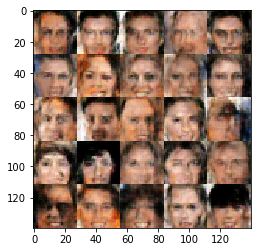

Epoch 1/4... Discriminator Loss: 0.9182... Generator Loss: 1.0341
Epoch 1/4... Discriminator Loss: 0.9128... Generator Loss: 0.8164
Epoch 1/4... Discriminator Loss: 0.7216... Generator Loss: 1.9417
Epoch 1/4... Discriminator Loss: 0.6720... Generator Loss: 2.3359
Epoch 1/4... Discriminator Loss: 0.5315... Generator Loss: 2.5108
Epoch 1/4... Discriminator Loss: 0.7698... Generator Loss: 2.8860
Epoch 1/4... Discriminator Loss: 0.5794... Generator Loss: 3.4997
Epoch 1/4... Discriminator Loss: 0.5802... Generator Loss: 3.2025
Epoch 1/4... Discriminator Loss: 0.9452... Generator Loss: 0.9831
Epoch 1/4... Discriminator Loss: 1.8159... Generator Loss: 0.4379


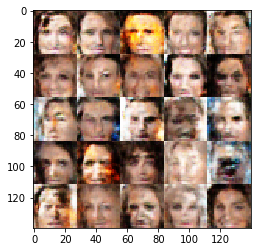

Epoch 1/4... Discriminator Loss: 1.3681... Generator Loss: 3.9553
Epoch 1/4... Discriminator Loss: 1.6719... Generator Loss: 4.5540
Epoch 1/4... Discriminator Loss: 0.7754... Generator Loss: 1.4091
Epoch 1/4... Discriminator Loss: 0.9327... Generator Loss: 0.9430
Epoch 1/4... Discriminator Loss: 1.0043... Generator Loss: 1.2175
Epoch 1/4... Discriminator Loss: 1.5393... Generator Loss: 5.2057
Epoch 1/4... Discriminator Loss: 0.5680... Generator Loss: 1.8648
Epoch 1/4... Discriminator Loss: 0.8237... Generator Loss: 1.2378
Epoch 1/4... Discriminator Loss: 0.6375... Generator Loss: 1.5949
Epoch 1/4... Discriminator Loss: 1.8768... Generator Loss: 0.4199


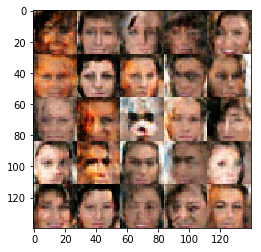

Epoch 1/4... Discriminator Loss: 0.6035... Generator Loss: 2.2026
Epoch 1/4... Discriminator Loss: 0.5599... Generator Loss: 2.6074
Epoch 1/4... Discriminator Loss: 0.5472... Generator Loss: 1.7473
Epoch 1/4... Discriminator Loss: 0.5461... Generator Loss: 2.3809
Epoch 1/4... Discriminator Loss: 0.5738... Generator Loss: 2.3516
Epoch 1/4... Discriminator Loss: 1.1884... Generator Loss: 0.7800
Epoch 1/4... Discriminator Loss: 1.0079... Generator Loss: 0.9703
Epoch 1/4... Discriminator Loss: 0.6574... Generator Loss: 2.3197
Epoch 1/4... Discriminator Loss: 0.6127... Generator Loss: 1.4165
Epoch 1/4... Discriminator Loss: 1.6098... Generator Loss: 5.4865


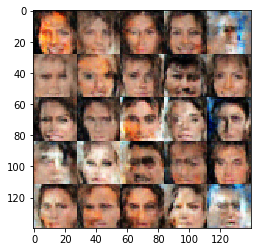

Epoch 1/4... Discriminator Loss: 0.7310... Generator Loss: 1.7005
Epoch 1/4... Discriminator Loss: 0.5659... Generator Loss: 2.1785
Epoch 1/4... Discriminator Loss: 1.0853... Generator Loss: 0.8080
Epoch 1/4... Discriminator Loss: 0.6796... Generator Loss: 1.6388
Epoch 1/4... Discriminator Loss: 0.4985... Generator Loss: 3.1914


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.